In [46]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
!pip install python_speech_features


In [48]:
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D , MaxPool2D , Flatten , LSTM
from keras.layers import Dropout , Dense , TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint

# New Section

In [49]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/instrumentals.csv") 
df = data.copy()
df.set_index("fname", inplace = True)
df.describe()

,label
count,2480
unique,10
top,Cello
freq,297


In [50]:
for f in df.index :
    rate , signal = wavfile.read('/content/drive/My Drive/Colab Notebooks/cleaner/'+f)
    df.at[f , 'length'] = (signal.shape[0]/rate)

In [51]:
classes = list(np.unique(df.label)) # all the unique_classes
class_dist = df.groupby(['label'])['length'].mean()

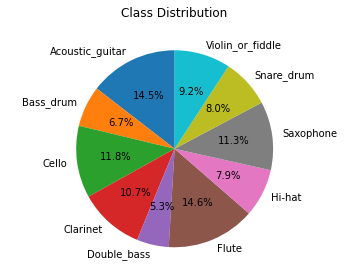

,label,length
fname,,
00044347.wav,Hi-hat,10.598375
001ca53d.wav,Saxophone,10.013438
00353774.wav,Cello,4.520000
003b91e8.wav,Cello,13.280000
004ad66f.wav,Clarinet,6.654063
...,...,...
ff3f21e7.wav,Snare_drum,6.195000
ff55a1e2.wav,Acoustic_guitar,14.660000
ff752a0c.wav,Clarinet,5.244562


In [52]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution' , y =1.08 )
ax.pie(class_dist, labels = class_dist.index , autopct ='%1.1f%%',shadow = False,startangle = 90)
ax.axis('equal')
plt.show()  # class imbalance can be clearly seen, collecting more data or dropping some data is not feasable in real world
df

In [53]:
# how to handle class imbalance when training
#audio is different from rest data because it is sampled so frequently and we have to create
#an arbitary length of time that we need to build a sample with,
#1 sample at 10th of second, we will randomly sample with length of audio file
# we  will take that 1 second chunk out of that audio, for samples to be huge, we will take twice that value

n_samples = 2 * int(df["length"].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p = prob_dist)
prob_dist

label
Acoustic_guitar     0.145228
Bass_drum           0.067255
Cello               0.118294
Clarinet            0.107023
Double_bass         0.052644
Flute               0.145623
Hi-hat              0.078989
Saxophone           0.112576
Snare_drum          0.080441
Violin_or_fiddle    0.091926
Name: length, dtype: float64

In [81]:
def check_data() :
    if os.path.isfile(config.p_path) :
        print('loading existing data for {} model'.format(config.mode))
        with open(config.p_path , 'rb') as handle :  #'rb' is read bytes
            tmp = pickle.load(handle)
            return tmp
    else :
        return None

In [82]:
def build_rand_feat() :
       
    X = []
    y = []
    _min , _max = float('inf') , -float('inf')
    for _ in tqdm(range(n_samples)) :
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate , wav = wavfile.read('/content/drive/My Drive/Colab Notebooks/cleaner/'+file)
        label = df.at[file , 'label'] # extra
        rand_index = np.random.randint(0 , wav.shape[0] - config.step) #config.step is 10th of second
        sample = wav[rand_index : rand_index + config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat,nfilt = config.nfilt,nfft=config.nfft)
        _min = min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))
    
    config.min = _min
    config.max = _max
    X,y = np.array(X) ,np.array(y)   
    X = (X - _min)/(_max - _min) # noramlising b/w 0 and 1
    if config.mode == 'conv' :
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode == 'time' :
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2])
    y = to_categorical(y,num_classes = 10) # to hot encode them, as y has classes 0-num_classes, each class was represented by index

    config.data = (X,y)
    
   # with open(config.p_path, 'wb') as handle :# wb is write bytes
   #     pickle.dump(config,handle,protocol = 2)
    return X,y


In [83]:
def get_conv_model() :
    model = Sequential()
    model.add(Conv2D(32, (3,3) ,activation = 'relu', strides=(1,1) , padding = 'same',input_shape = input_shape))
    model.add(Conv2D(64, (3,3) ,activation = 'relu', strides=(1,1) , padding = 'same'))
    model.add(Conv2D(128, (3,3) ,activation = 'relu', strides=(1,1) , padding = 'same'))
    model.add(Conv2D(256, (3,3) ,activation = 'relu', strides=(1,1) , padding = 'same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    return model

In [84]:
def get_recurrent_model() :
    model = Sequential()
    model.add(LSTM(128, return_sequences = True,input_shape = input_shape))
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation = "relu")))
    model.add(TimeDistributed(Dense(32, activation = "relu")))
    model.add(TimeDistributed(Dense(16, activation = "relu")))
    model.add(TimeDistributed(Dense(8, activation = "relu")))
    model.add(Flatten())
    model.add(Dense(10, activation = 'softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    return model

In [85]:
import os

class Config :                                                 # because we have down-sampled
    def __init__(self ,mode = "conv" , nfilt = 26 , nfeat = 13, nfft = 512 , rate = 16000) :
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)
        self.model_path = os.path.join("models",mode + ".model")
        self.p_path = os.path.join("pickles",mode + ".p")

In [86]:
config = Config(mode = "conv")

if config.mode == "conv" :
    X , y = build_rand_feat()
    y_flat =  np.argmax(y, axis = 1)
    input_shape = (X.shape[1] , X.shape[2] , 1)
    model = get_conv_model()
    model = get_conv_model()
    
elif config.mode == "time" :
    X,y = build_rand_feat() 
    y_flat =  np.argmax(y, axis = 1)
    input_shape = (X.shape[1] , X.shape[2]) 
    model = get_recurrent_model()

100%|██████████| 313690/313690 [23:13<00:00, 225.08it/s]


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 9, 13, 32)         320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 13, 128)        73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 9, 13, 256)        295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 6, 256)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 6, 256)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6144)             

In [87]:
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)

In [88]:
checkpoint = ModelCheckpoint(config.model_path, monitor = 'val_acc',verbose=1, mode = 'max',
                            save_best_only = True, save_weights_only = False, period = 1)

In [89]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y)

In [90]:


history = model.fit(x_train,y_train,epochs=50,batch_size=32,shuffle=True,validation_split = 0.1, callbacks = [checkpoint])

Epoch 1/50
6616/6617 [============================>.] - ETA: 0s - loss: 0.9652 - acc: 0.6607
Epoch 00001: val_acc improved from -inf to 0.76691, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets
6617/6617 [==============================] - 74s 11ms/step - loss: 0.9652 - acc: 0.6607 - val_loss: 0.6804 - val_acc: 0.7669
Epoch 2/50
6614/6617 [============================>.] - ETA: 0s - loss: 0.6258 - acc: 0.7844
Epoch 00002: val_acc improved from 0.76691 to 0.82535, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets
6617/6617 [==============================] - 73s 11ms/step - loss: 0.6258 - acc: 0.7844 - val_loss: 0.5113 - val_acc: 0.8253
Epoch 3/50
6616/6617 [============================>.] - ETA: 0s - loss: 0.5209 - acc: 0.8202
Epoch 00003: val_acc improved from 0.82535 to 0.83300, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets
6617/6617 [================

In [91]:
y_pred = model.predict(x_test)

In [92]:
y_pred = (y_pred > 0.5) 
y_pred

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False]])

In [93]:
y_test = (y_test > 0.5) 
y_test

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False]])

In [94]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     11534
           1       0.93      0.95      0.94      5372
           2       0.91      0.91      0.91      9244
           3       0.96      0.95      0.95      8168
           4       0.89      0.84      0.86      4164
           5       0.94      0.94      0.94     11504
           6       0.97      0.97      0.97      6252
           7       0.96      0.91      0.93      8694
           8       0.97      0.92      0.95      6318
           9       0.93      0.93      0.93      7173

   micro avg       0.94      0.93      0.93     78423
   macro avg       0.94      0.92      0.93     78423
weighted avg       0.94      0.93      0.93     78423
 samples avg       0.93      0.93      0.93     78423



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


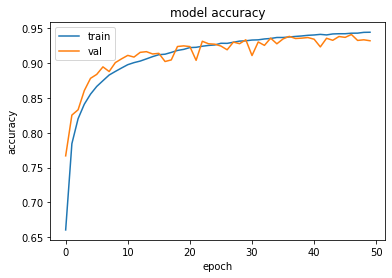

In [95]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


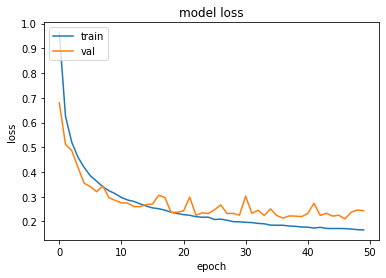

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
